<a href="https://www.kaggle.com/code/aathomas707/detecting-pneumonia-cnn-vit-xai?scriptVersionId=288788632" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing necessary libraries

In [ ]:
# Restart kernel after installation
%pip install --upgrade transformers peft accelerate grad-cam "numpy<2.0"

# Exploring the Data & Preprocessing
I'm printing out the number of images in each folder in the dataset.

Image Counts:
  Dataset      Class  Count
0   train     NORMAL   1341
1   train  PNEUMONIA   3875
2     val     NORMAL      8
3     val  PNEUMONIA      8
4    test     NORMAL    234
5    test  PNEUMONIA    390




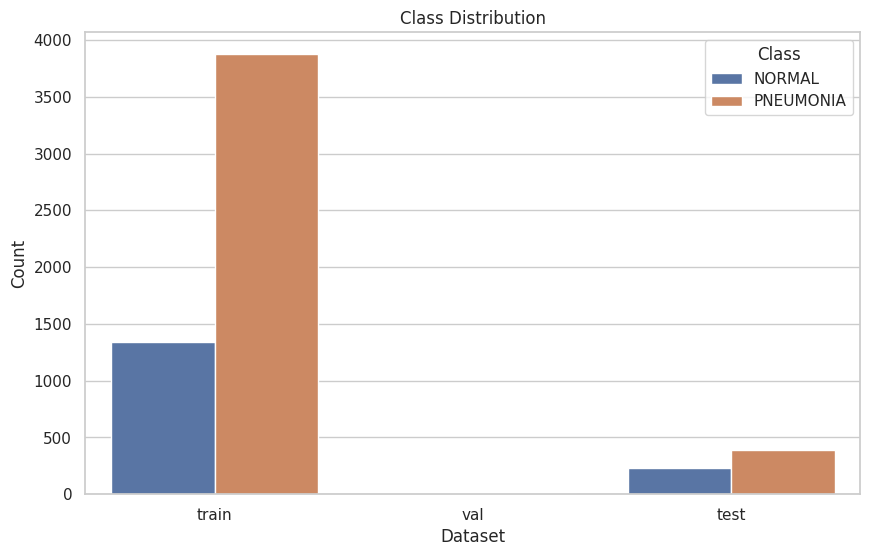

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# checking if path exists 
base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
if os.path.exists(os.path.join(base_path, 'chest_xray')):
    base_path = os.path.join(base_path, 'chest_xray')




sets = ['train', 'val', 'test']
categories = ['NORMAL', 'PNEUMONIA']
data = []

for dataset in sets:
    for category in categories:
        folder_path = os.path.join(base_path, dataset, category)
        
        # Check if path exists to avoid errors
        if os.path.exists(folder_path):
            # Count files (filtering for likely image formats to be safe)
            num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
            data.append([dataset, category, num_images])
        else:
            print(f"Warning: Directory not found: {folder_path}")

# Creating a DataFrame for clean viewing
df = pd.DataFrame(data, columns=['Dataset', 'Class', 'Count'])

# Display the Table
print("Image Counts:")
print(df)
print("\n")

# Analysis 
train_normal = df[(df['Dataset']=='train') & (df['Class']=='NORMAL')]['Count'].values[0]
train_pneumonia = df[(df['Dataset']=='train') & (df['Class']=='PNEUMONIA')]['Count'].values[0]
val_total = df[df['Dataset']=='val']['Count'].sum()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Dataset', y='Count', hue='Class')
plt.title('Class Distribution')
plt.show()

Here, we find two things:
- Pneumonia images are more in number than the Normal images
- The validation folder has only 16 images, which is not enough

How we can solve these:
- We use a WeightedRandomSampler to make sure each batch during training has a balanced representation.
- We combine the train and val folders and then split them with test size 0.20 for a better validation set.

In [65]:
from sklearn.model_selection import train_test_split

base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
if os.path.exists(os.path.join(base_path, 'chest_xray')):
    base_path = os.path.join(base_path, 'chest_xray')

# Collecting files from train and val
folders_to_combine = ['train', 'val']
data = []

for folder in folders_to_combine:
    for class_name, label in [('NORMAL', 0), ('PNEUMONIA', 1)]:
        folder_path = os.path.join(base_path, folder, class_name)
        
        # Iterate through files
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(folder_path, filename)
                data.append({
                    'filepath': full_path,
                    'label': label,
                    'class_name': class_name
                })

# Create the Master DataFrame
full_df = pd.DataFrame(data)
print(f"Total images collected for training pool: {len(full_df)}")

# Stratified Split (80/20) - ensures both sets maintain the same ratio of Pneumonia to Normal
train_df, val_df = train_test_split(
    full_df, 
    test_size=0.20, 
    random_state=42, 
    stratify=full_df['label']
)

# Verify the New Split
print("\nNew Split Statistics:")
print(f"Train Set Size: {len(train_df)}")
print(f"Val Set Size:   {len(val_df)}")

print("\nClass Distribution in Training Set:")
print(train_df['class_name'].value_counts())

print("\nClass Distribution in Validation Set:")
print(val_df['class_name'].value_counts())

# Optional: Preview the data
print("\nSample Data:")
print(train_df.head())

Total images collected for training pool: 5232

New Split Statistics:
Train Set Size: 4185
Val Set Size:   1047

Class Distribution in Training Set:
class_name
PNEUMONIA    3106
NORMAL       1079
Name: count, dtype: int64

Class Distribution in Validation Set:
class_name
PNEUMONIA    777
NORMAL       270
Name: count, dtype: int64

Sample Data:
                                               filepath  label class_name
3558  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1  PNEUMONIA
2858  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1  PNEUMONIA
2673  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1  PNEUMONIA
1199  /kaggle/input/chest-xray-pneumonia/chest_xray/...      0     NORMAL
4611  /kaggle/input/chest-xray-pneumonia/chest_xray/...      1  PNEUMONIA


### Applying CLAHE to Enhance the Image 

In [66]:
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch

#Custom Transform for CLAHE (Contrast Enhancement)
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL to CV2 (Grayscale)
        img_np = np.array(img)
        
        # Ensure it's grayscale for CLAHE
        if len(img_np.shape) == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(img_np)
        
        # Convert back to PIL RGB (important for Pre-trained models)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(img_clahe)

def get_transforms(split):
    if split == 'train':
        return T.Compose([
            T.Resize((224, 224)),
            CLAHETransform(),                 
            

            T.RandomHorizontalFlip(p=0.5),    
            T.RandomRotation(15),             
            T.RandomAffine(
                degrees=0, 
                translate=(0.1, 0.1),         
                scale=(0.9, 1.1)             
            ),
            
            T.ColorJitter(brightness=0.2, contrast=0.2), 
            
            # Randomly blurs images to force model to look at larger shapes, not pixel noise
            T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
            
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else: 
        return T.Compose([
            T.Resize((224, 224)),
            CLAHETransform(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [67]:
class XRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['filepath']
        label = row['label']
        
        image = Image.open(img_path).convert("RGB")
        
        # Apply Transforms
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)


train_ds = XRayDataset(train_df, transform=get_transforms('train'))
val_ds = XRayDataset(val_df, transform=get_transforms('val'))

### WeightedRandomSampler for balanced representation

In [68]:
from torch.utils.data import WeightedRandomSampler

# Count samples per class in the TRAINING set
class_counts = train_df['label'].value_counts().sort_index().values 

# Weight = 1 / Count (fewer the samples, the higher the weight)
class_weights = 1.0 / class_counts

# Assign a weight to every single image in the dataset
sample_weights = [class_weights[label] for label in train_df['label']]

# Create the Sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights), # Total size of dataset
    replacement=True # Allow picking the same Normal image multiple times in an epoch
)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler,shuffle=False, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

In [69]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Helper Function - Denormalize for Visualization
# Reverse ImageNet normalization: Image = (Tensor * Std) + Mean
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    img = tensor * std + mean
    
    # Clip values to 0-1 range to avoid display artifacts
    img = torch.clamp(img, 0, 1)
    
    # Convert from PyTorch format (Channels, Height, Width) to Matplotlib format (Height, Width, Channels)
    return img.permute(1, 2, 0).numpy()


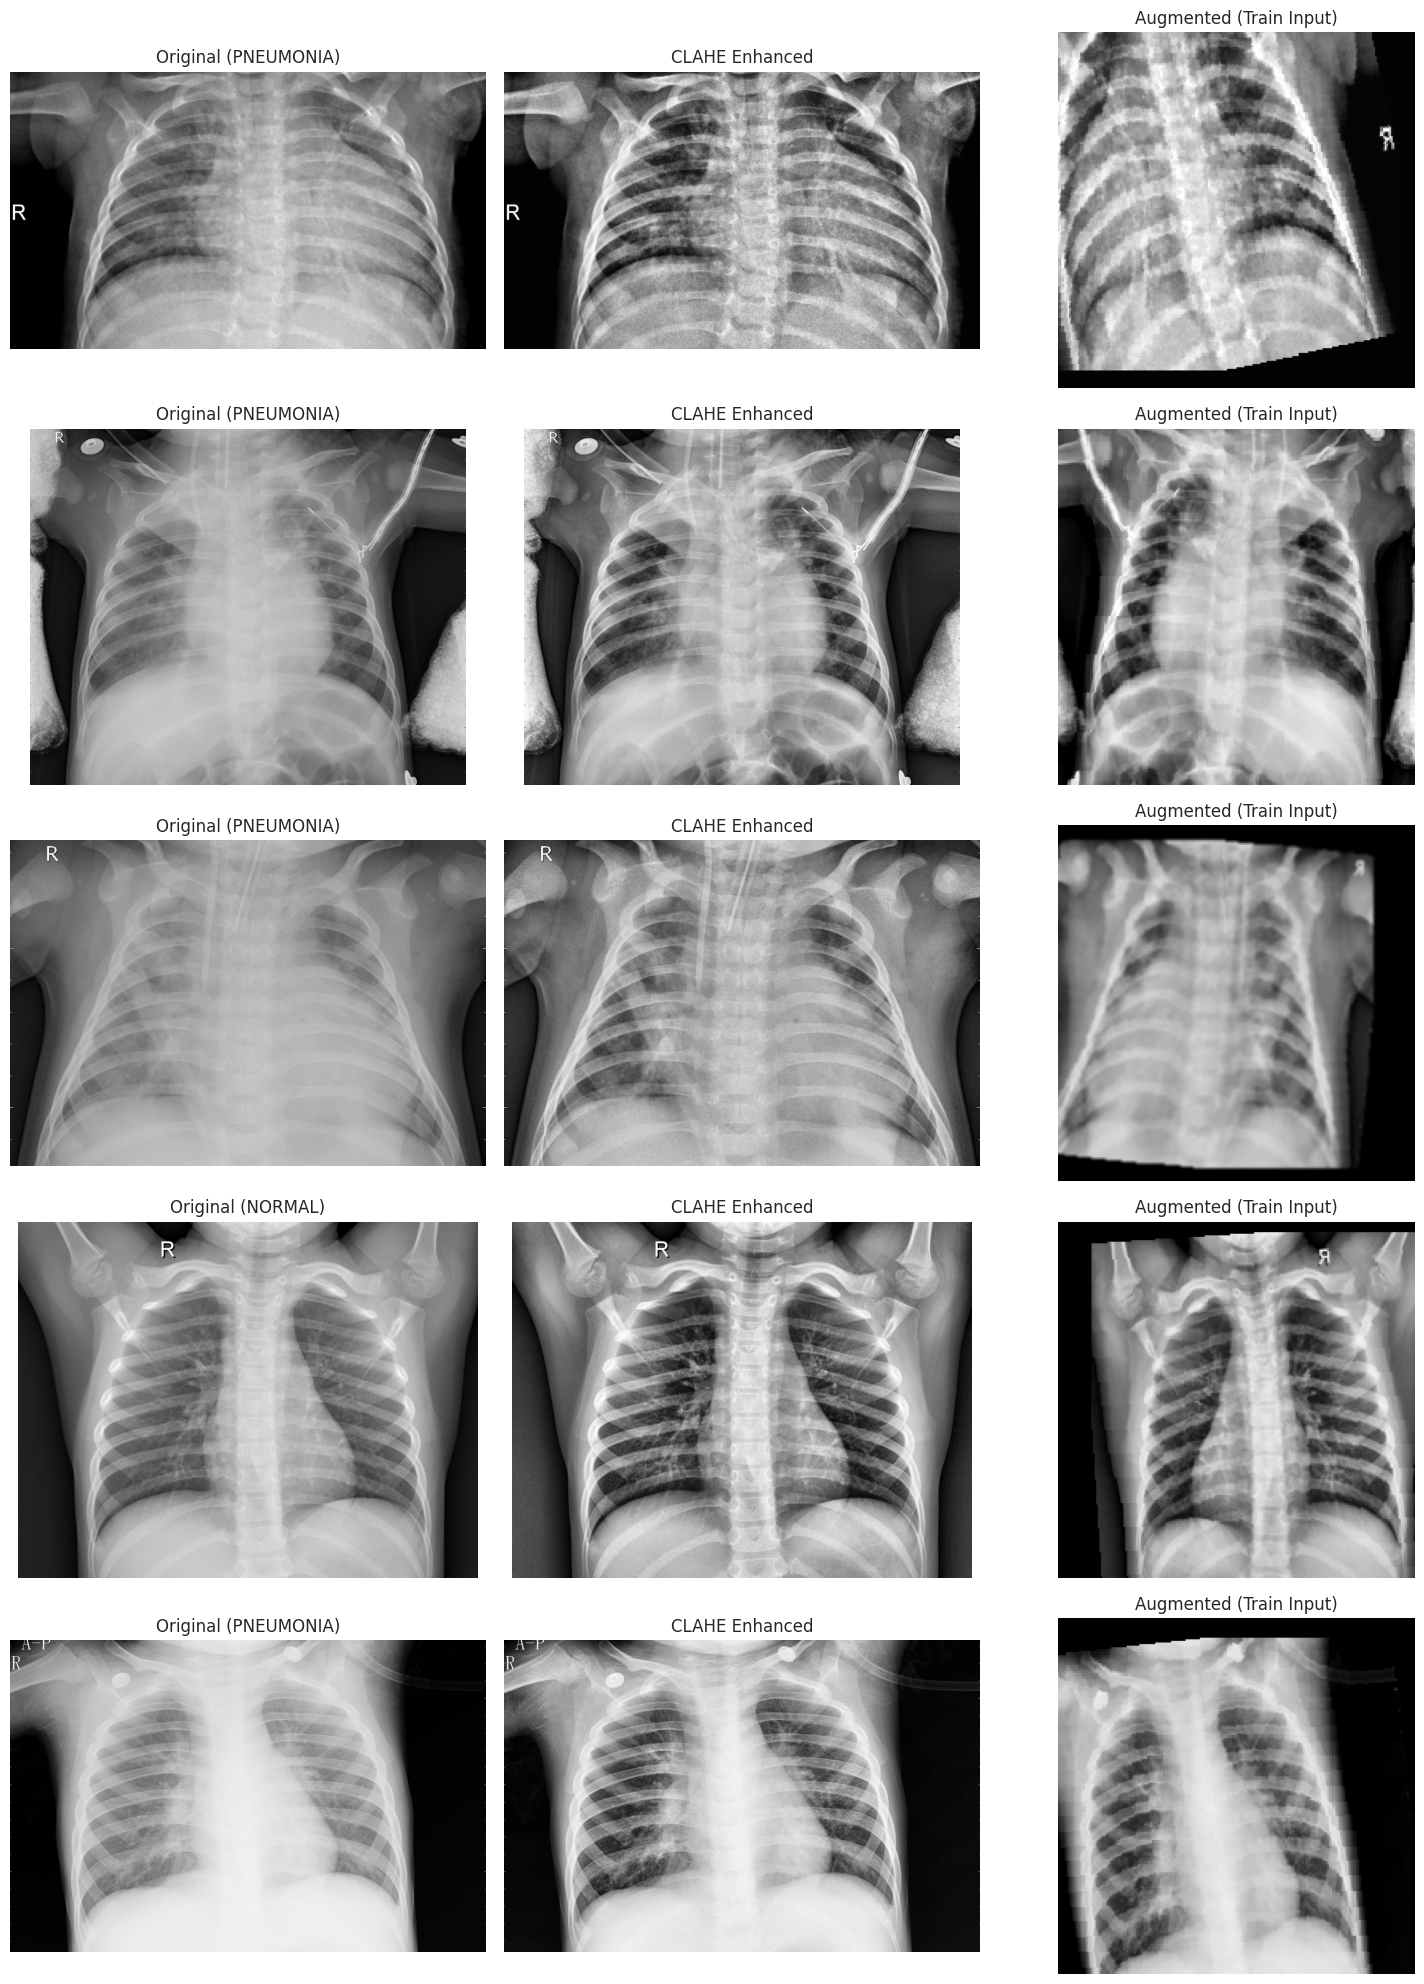

In [70]:
import random

num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 20)) # Tall figure for 5 rows

# Get 5 random samples from the DataFrame
samples = train_df.sample(num_samples).reset_index(drop=True)

clahe_transform = CLAHETransform(clip_limit=2.0)
train_aug_transform = get_transforms('train')

for i, row in samples.iterrows():
    # Load Original
    img_path = row['filepath']
    label_name = row['class_name']
    original_img = Image.open(img_path).convert("RGB")
    
    clahe_img = clahe_transform(original_img)
    
    # Apply Full Augmentation (and denormalize for viewing)
    aug_tensor = train_aug_transform(original_img)
    aug_img = denormalize(aug_tensor)
    
    
    # Original
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(f"Original ({label_name})")
    axes[i, 0].axis('off')
    
    # CLAHE
    axes[i, 1].imshow(clahe_img)
    axes[i, 1].set_title("CLAHE Enhanced")
    axes[i, 1].axis('off')
    
    # Final Input
    axes[i, 2].imshow(aug_img)
    axes[i, 2].set_title("Augmented (Train Input)")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# CNN + GradCAM

In [71]:
import torch
import torch.nn as nn
from torchvision import models

def get_cnn_model(device):
    # default weights - loads the best available ImageNet weights
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Freeze Early Layers - prevents destroying the pre-trained features in the first few epochs.
    for param in model.parameters():
        param.requires_grad = False  # Freeze all
        
    # Unfreeze the last block (Layer 4) so it can learn the lung textures
    for param in model.layer4.parameters():
        param.requires_grad = True
        
    # Modify the Head - the Classifier 
    # ResNet original fc layer: (2048 -> 1000)
    # We change it to: (2048 -> 2) for our classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4), # Prevents overfitting
        nn.Linear(512, 2) # Output: Normal, Pneumonia
    )
    
    return model.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = get_cnn_model(device)

print(f"Model initialized on {device}")
print(cnn_model.fc)

Model initialized on cuda
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


### Training ResNet50 on the dataset 

In [72]:
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm

weights = torch.tensor(class_weights).float().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=0.05)


def train_model(model, train_loader, val_loader, train_size, val_size, epochs=1):
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 10)

    
        model.train()  
        running_loss = 0.0
        correct = 0
        
        # Training Loop
        loop = tqdm(train_loader, leave=True, desc="Training")
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / train_size
        train_acc = correct.double() / train_size

   
        model.eval()   
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
        
        val_loss_epoch = val_loss / val_size
        val_acc = val_correct.double() / val_size


        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss_epoch:.4f} Acc: {val_acc:.4f}")


print("Starting Training with Validation...")
train_model(cnn_model, train_loader, val_loader, len(train_df), len(val_df), epochs=5)

Starting Training with Validation...

Epoch 1/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.3797 Acc: 0.8370
Val   Loss: 0.1700 Acc: 0.9303

Epoch 2/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.1788 Acc: 0.9338
Val   Loss: 0.3024 Acc: 0.8453

Epoch 3/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.1650 Acc: 0.9384
Val   Loss: 0.1313 Acc: 0.9628

Epoch 4/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.1249 Acc: 0.9575
Val   Loss: 0.1059 Acc: 0.9551

Epoch 5/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.1204 Acc: 0.9575
Val   Loss: 0.1716 Acc: 0.9475


### Adding GradCAM to the trained model

In [73]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, image_tensor, original_image_np):   
    # Define Target Layer (Last Conv Layer of ResNet50)
    target_layers = [model.layer4[-1]]

    # Initialize GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Run GradCAM
    # We don't specify targets so it defaults to the highest predicted class
    grayscale_cam = cam(input_tensor=image_tensor)

    # Overlay Heatmap on Image
    grayscale_cam = grayscale_cam[0, :] # Take first item in batch
    visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
    
    return visualization

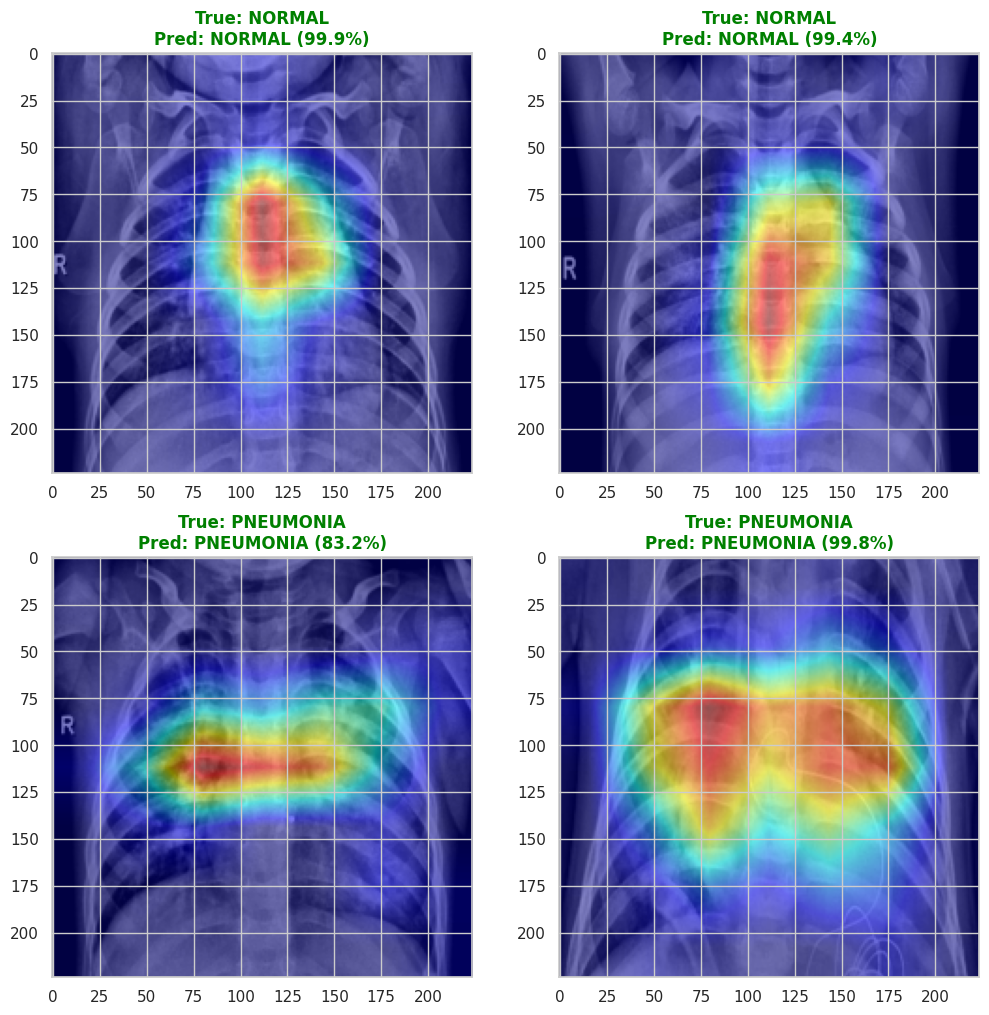

In [74]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from PIL import Image

def predict_and_explain(model, img_path, true_label_name):
    # Prepare Image - Load and convert to RGB
    img = Image.open(img_path).convert("RGB")
    
    # Apply Validation Transforms (CLAHE + Resize + Normalize)
    # Using the 'val' transform we defined earlier so there is no random rotation
    val_transform = get_transforms('val') 
    img_tensor = val_transform(img).unsqueeze(0).to(device) # Add batch dimension -> (1, 3, 224, 224)
    
    # Get Model Prediction
    model.eval() 
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1) # Get probabilities (0-1)
        conf, pred_idx = torch.max(probs, 1) # Get max probability and index
    
    pred_label_name = 'PNEUMONIA' if pred_idx.item() == 1 else 'NORMAL'
    confidence = conf.item() * 100
    
    # Generate Grad-CAM
    # We need gradients, so we re-enable them just for this step
    with torch.set_grad_enabled(True):
        # Target the last layer of ResNet
        target_layers = [model.layer4[-1]]
        cam = GradCAM(model=model, target_layers=target_layers)
        
        # Generate raw CAM
        grayscale_cam = cam(input_tensor=img_tensor)[0, :]
        
        # Get background image (Denormalized) for overlay
        rgb_img = denormalize(img_tensor.squeeze().cpu())
        
        # Create Heatmap Overlay
        heatmap = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
    return heatmap, pred_label_name, confidence


# Grab 2 Random Normal and 2 Random Pneumonia from Validation DataFrame
samples_normal = val_df[val_df['class_name'] == 'NORMAL'].sample(2)
samples_pneumonia = val_df[val_df['class_name'] == 'PNEUMONIA'].sample(2)
samples = pd.concat([samples_normal, samples_pneumonia])


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, (_, row) in enumerate(samples.iterrows()):
    path = row['filepath']
    true_label = row['class_name']
    
   
    heatmap, pred_label, conf = predict_and_explain(cnn_model, path, true_label)
    
   
    color = 'green' if true_label == pred_label else 'red'
    
   
    axes[i].imshow(heatmap)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({conf:.1f}%)", color=color, fontweight='bold')

### Performance metrics of the model

Test Set Size: 624 images
Running inference on Test Set...


  0%|          | 0/20 [00:00<?, ?it/s]


FINAL TEST RESULTS
Global Accuracy: 90.38%

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86       234
   Pneumonia       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



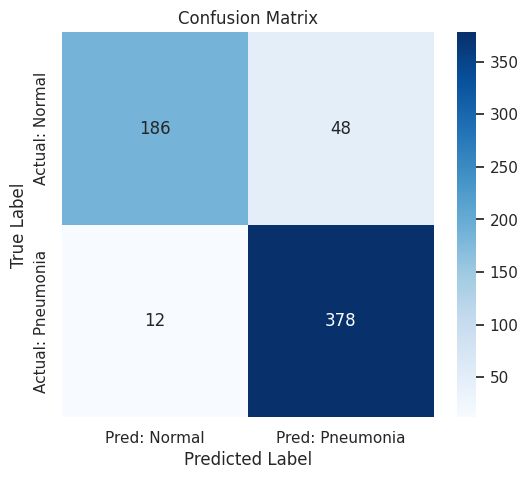

In [75]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


test_data = []
test_path = os.path.join(base_path, 'test')

for class_name, label in [('NORMAL', 0), ('PNEUMONIA', 1)]:
    folder_path = os.path.join(test_path, class_name)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_data.append({
                'filepath': os.path.join(folder_path, filename),
                'label': label
            })

test_df = pd.DataFrame(test_data)
print(f"Test Set Size: {len(test_df)} images")

# --- 2. Create Test Loader ---
# Use 'val' transforms (No augmentation, just resize/normalize)
test_ds = XRayDataset(test_df, transform=get_transforms('val'))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# --- 3. Run Predictions ---
y_true = []
y_pred = []

cnn_model.eval() # Safety: Turn off dropout/batchnorm updates
print("Running inference on Test Set...")

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move to CPU and convert to numpy for sklearn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 4. Generate Metrics ---
print("\n" + "="*30)
print("FINAL TEST RESULTS")
print("="*30)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Global Accuracy: {acc*100:.2f}%\n")

# Detailed Report (Precision, Recall, F1)
print("--- Classification Report ---")
cr_cnn = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'],output_dict=True)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# --- 5. Confusion Matrix Visualization ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: Pneumonia'],
            yticklabels=['Actual: Normal', 'Actual: Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ViT + Attention Rollout


In [76]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification, ViTConfig


class ChestViT(nn.Module):
    def __init__(self, num_labels=2):
        super(ChestViT, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        
    def forward(self, x):
        return self.vit(x).logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ChestViT(num_labels=2).to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# Normal (Class 0) = 3.0 (Higher priority because fewer samples)
# Pneumonia (Class 1) = 1.0

# weights = torch.tensor(class_weights).float().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=0.05)


# weights = torch.tensor([3.0, 1.0]).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.AdamW(vit_model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=2e-5, weight_decay=0.02)

def train_vit(model, train_loader, val_loader, train_size, val_size, epochs=3):
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 10)

        model.train()  # Enable Dropout & BatchNorm
        running_loss = 0.0
        correct = 0
        
        loop = tqdm(train_loader, leave=True, desc="Training")
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward Pass
            outputs = model(images)
            
            # Robust Check: Handle both HF Output Objects and Raw Tensors
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs
            
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            optimizer.step()
            
            # Stats
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits, 1)
            correct += torch.sum(preds == labels.data)
            
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / train_size
        train_acc = correct.double() / train_size


        model.eval()  # Freeze Dropout & BatchNorm
        val_loss = 0.0
        val_correct = 0
        

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                
                # Robust Check again
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    logits = outputs
                    
                loss = criterion(logits, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(logits, 1)
                val_correct += torch.sum(preds == labels.data)
        
        val_loss_epoch = val_loss / val_size
        val_acc = val_correct.double() / val_size

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss_epoch:.4f} | Acc: {val_acc:.4f}")


# Pass both loaders and both dataset sizes
train_vit(vit_model, train_loader, val_loader, len(train_df), len(val_df), epochs=5)


Epoch 1/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.2167 | Acc: 0.9080
Val   Loss: 0.1800 | Acc: 0.9255

Epoch 2/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.1040 | Acc: 0.9649
Val   Loss: 0.2934 | Acc: 0.8949

Epoch 3/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.0783 | Acc: 0.9728
Val   Loss: 0.2086 | Acc: 0.9140

Epoch 4/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.0632 | Acc: 0.9771
Val   Loss: 0.1888 | Acc: 0.9341

Epoch 5/5
----------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.0609 | Acc: 0.9795
Val   Loss: 0.1366 | Acc: 0.9484


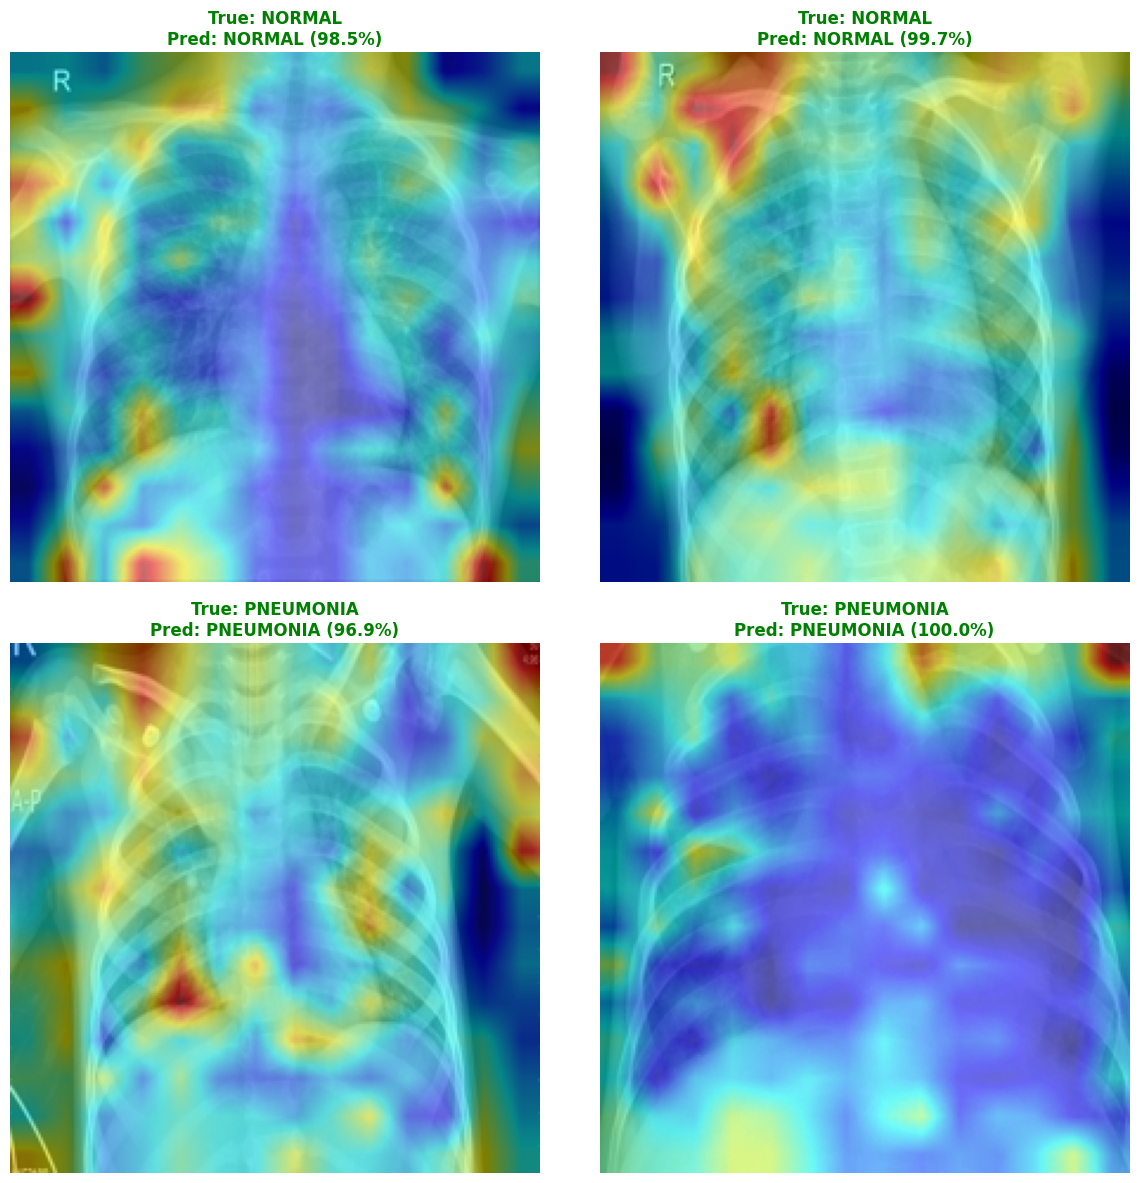

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import copy
from PIL import Image
from transformers import ViTConfig, ViTForImageClassification


def get_viz_model(model):

    if hasattr(model, 'vit') and isinstance(model.vit, torch.nn.Module):
        original_model = model.vit
    else:
        original_model = model

    device = next(original_model.parameters()).device
    
    # Deep copy the config so we don't mess up the training model
    conf = copy.deepcopy(original_model.config)
    
    # Force "Eager" mode (standard attention)s
    setattr(conf, "attn_implementation", "eager")
    setattr(conf, "_attn_implementation", "eager") 
    
    # Force Output Flags
    conf.output_attentions = True
    conf.return_dict = True
    
    # Re-initialize the model structure using the forced config
    viz_model = ViTForImageClassification(conf)
    
    # Load the trained weights (strict=False avoids crashes on minor version mismatches)
    viz_model.load_state_dict(original_model.state_dict(), strict=False)
    viz_model.to(device)
    viz_model.eval()
    
    return viz_model

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, use_rgb: bool = False, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    
    if np.max(img) > 1:
        raise Exception("The input image should be float32 in the range [0, 1]")
    
    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def get_attention_map(model, img_path):

    viz_model = get_viz_model(model)
    
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((224, 224))
    
    val_transform = get_transforms('val')
    img_tensor = val_transform(img_resized).unsqueeze(0).to(device)
    

    with torch.no_grad():
        # Pass output_attentions=True explicitly to be absolutely sure
        outputs = viz_model(pixel_values=img_tensor, output_attentions=True)
        
        attentions = outputs.attentions
        logits = outputs.logits


    if attentions is None:
        # Debugging fallback: If attentions is still None, check if it's hidden in a tuple
        if isinstance(outputs, tuple):
             for item in outputs:
                 if isinstance(item, tuple): # attentions is usually a tuple of tensors
                     attentions = item
                     break
        
        if attentions is None:
            # If we reach here, the model is fundamentally refusing to output attentions.
            raise ValueError("The model is still ignoring 'output_attentions=True'. " 
                             "This suggests the 'attn_implementation' override failed.")

  
    # Stack layers -> (Layers, Heads, Patches, Patches)
    att_mat = torch.stack(attentions).squeeze(1) 
    
    # Average over heads -> (Layers, Patches, Patches)
    att_mat = torch.mean(att_mat, dim=1) 
    
    # Add identity matrix (residual connection)
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursive Matrix Multiplication
    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Extract [CLS] token attention map
    mask = joint_attentions[-1, 0, 1:] 
    
    # Reshape (14x14)
    grid_size = int(np.sqrt(mask.size(0)))
    mask = mask.reshape(grid_size, grid_size).cpu().numpy()
    
    # Normalize & Resize
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = cv2.resize(mask, (224, 224))
    
    # Overlay on the resized original image
    rgb_img = np.array(img_resized)
    rgb_img = np.float32(rgb_img) / 255
    heatmap = show_cam_on_image(rgb_img, mask, use_rgb=True)
    
    # Prediction Label
    probs = torch.nn.functional.softmax(logits, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    pred_label = "PNEUMONIA" if pred_idx.item() == 1 else "NORMAL"
    
    return heatmap, pred_label, conf.item() * 100


# Grab 2 Random Normal and 2 Random Pneumonia samples
samples_normal = val_df[val_df['class_name'] == 'NORMAL'].sample(2)
samples_pneumonia = val_df[val_df['class_name'] == 'PNEUMONIA'].sample(2)
samples = pd.concat([samples_normal, samples_pneumonia])


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()


for i, (_, row) in enumerate(samples.iterrows()):
    path = row['filepath']
    true_label = row['class_name']
    
    try:
     
        heatmap, pred_label, conf = get_attention_map(vit_model, path)
        
       
        color = 'green' if true_label == pred_label else 'red'
        
       
        axes[i].imshow(heatmap)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({conf:.1f}%)", color=color, fontweight='bold')
        axes[i].axis('off')
    except Exception as e:
        print(f"Error processing {path}: {e}")
        axes[i].text(0.5, 0.5, "Error Generating Map", ha='center')

plt.tight_layout()
plt.show()

Test Set Loaded: 624 images
Running ViT Inference on Test Set...


  0%|          | 0/20 [00:00<?, ?it/s]


ViT FINAL TEST RESULTS
Global Accuracy: 92.31%

ROC AUC Score: 0.9794

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.95      0.84      0.89       234
   Pneumonia       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



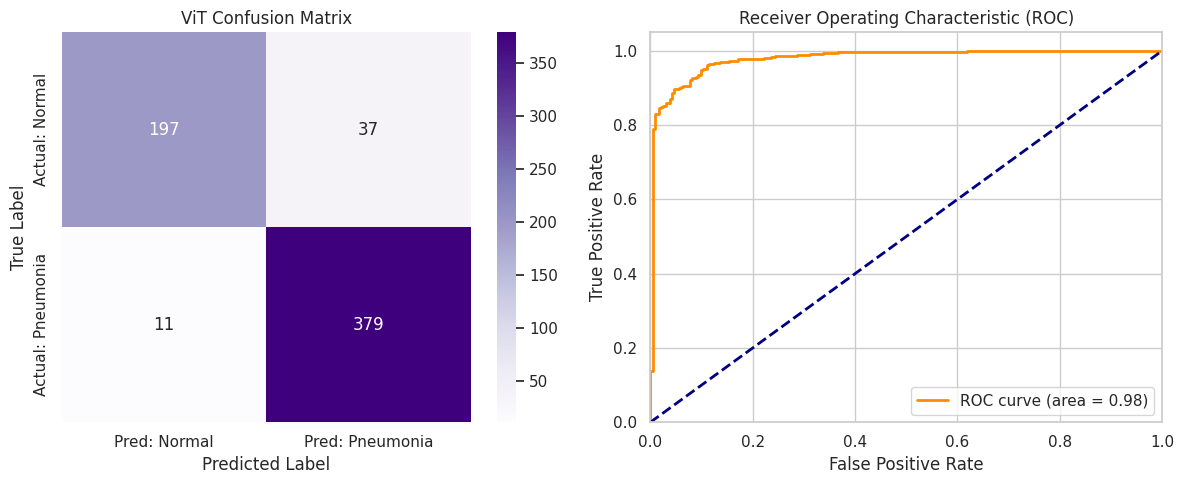

In [78]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import torch.nn.functional as F
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


test_data = []
test_path = os.path.join(base_path, 'test')



for class_name, label in [('NORMAL', 0), ('PNEUMONIA', 1)]:
    folder_path = os.path.join(test_path, class_name)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_data.append({
                    'filepath': os.path.join(folder_path, filename),
                    'label': label
                })

test_df = pd.DataFrame(test_data)
print(f"Test Set Loaded: {len(test_df)} images")

# Create Loader (Standard Validation Transforms)
test_ds = XRayDataset(test_df, transform=get_transforms('val'))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


y_true = []
y_pred = []
y_probs = [] # Storing probabilities for ROC-AUC

vit_model.eval() 
print("Running ViT Inference on Test Set...")

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # The wrapper already returns logits (Tensor), so we don't use .logits again
        logits = vit_model(images)
        
        # Calculate Probabilities (Softmax)
        probs = F.softmax(logits, dim=1)
        
        # Get Predictions (Class Index)
        _, preds = torch.max(logits, 1)
        
        # Save results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy()) # Save probability of Pneumonia (Class 1)


print("\n" + "="*30)
print("ViT FINAL TEST RESULTS")
print("="*30)

# Global Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Global Accuracy: {acc*100:.2f}%\n")

# ROC AUC Score (Standard for Medical Imaging)
try:
    roc_auc = roc_auc_score(y_true, y_probs)
    print(f"ROC AUC Score: {roc_auc:.4f}\n")
except:
    print("Could not calculate ROC AUC (perhaps only one class in test set)\n")

# Detailed Report
print("--- Classification Report ---")
cr_vit = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'],output_dict=True)
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['Pred: Normal', 'Pred: Pneumonia'],
            yticklabels=['Actual: Normal', 'Actual: Pneumonia'])
axes[0].set_title('ViT Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Comparing both models

Generating comparisons for 3 images:


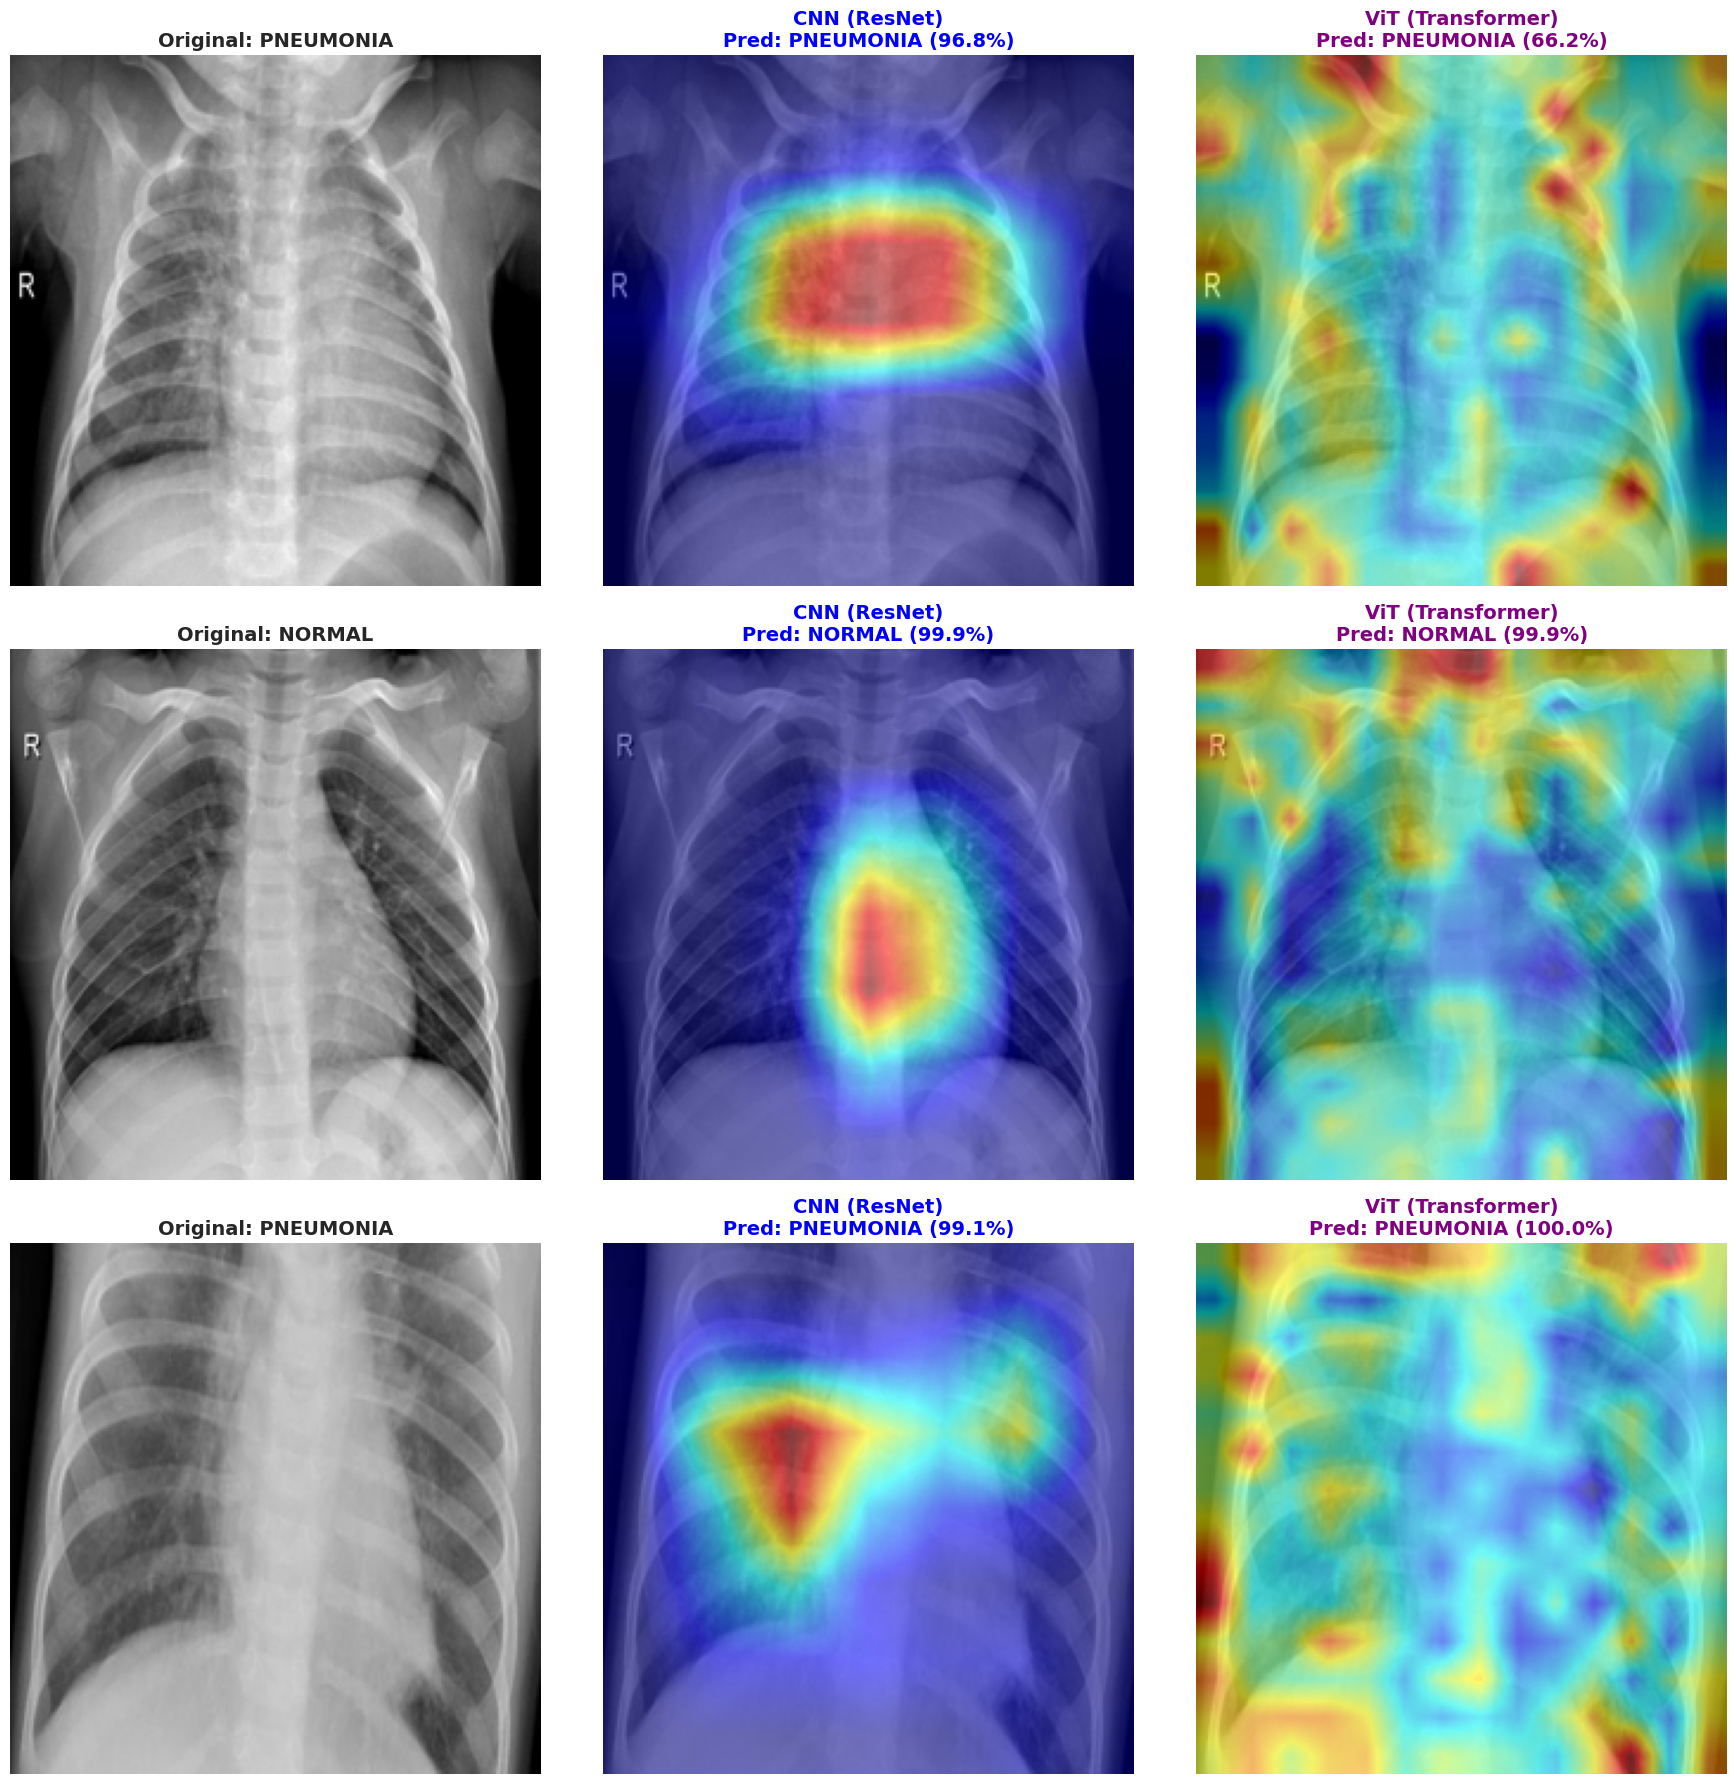

In [80]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import copy
import pandas as pd
from PIL import Image
from pytorch_grad_cam import GradCAM
from transformers import ViTForImageClassification


def show_cam_on_image(img: np.ndarray, mask: np.ndarray, use_rgb: bool = False, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def get_viz_model(model):
    """ Creates a guaranteed 'eager' mode clone of the model. """
    if hasattr(model, 'vit') and isinstance(model.vit, torch.nn.Module):
        original_model = model.vit
    else:
        original_model = model

    device = next(original_model.parameters()).device
    
    # Deep copy config and force Eager mode
    conf = copy.deepcopy(original_model.config)
    setattr(conf, "attn_implementation", "eager")
    setattr(conf, "_attn_implementation", "eager")
    conf.output_attentions = True
    conf.return_dict = True
    
    # Create Clone
    viz_model = ViTForImageClassification(conf)
    viz_model.load_state_dict(original_model.state_dict(), strict=False)
    viz_model.to(device)
    viz_model.eval()
    return viz_model

def get_vit_rollout(model, img_path):

    viz_model = get_viz_model(model)
    
    # Prepare Image
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((224, 224))
    val_transform = get_transforms('val')
    img_tensor = val_transform(img_resized).unsqueeze(0).to(device)
    
    # Run Model
    with torch.no_grad():
        outputs = viz_model(pixel_values=img_tensor, output_attentions=True)
        attentions = outputs.attentions
        logits = outputs.logits


    if attentions is None:
        raise ValueError("Model failed to return attentions.")

    att_mat = torch.stack(attentions).squeeze(1) 
    att_mat = torch.mean(att_mat, dim=1) 
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    mask = joint_attentions[-1, 0, 1:] 
    grid_size = int(np.sqrt(mask.size(0)))
    mask = mask.reshape(grid_size, grid_size).cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = cv2.resize(mask, (224, 224))
    
    rgb_img = np.array(img_resized)
    rgb_img = np.float32(rgb_img) / 255
    heatmap = show_cam_on_image(rgb_img, mask, use_rgb=True)
    
    probs = torch.nn.functional.softmax(logits, dim=1)
    conf, pred_idx = torch.max(probs, 1)
    pred = "PNEUMONIA" if pred_idx.item() == 1 else "NORMAL"
    
    return heatmap, pred, conf.item() * 100


def get_resnet_gradcam(model, img_path):
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((224, 224))
    val_transform = get_transforms('val')
    img_tensor = val_transform(img_resized).unsqueeze(0).to(device)
    
    target_layers = [model.layer4[-1]]
    
    with torch.set_grad_enabled(True):
        cam = GradCAM(model=model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0, :]
    
    rgb_img = np.array(img_resized)
    rgb_img = np.float32(rgb_img) / 255
    heatmap = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)
    
    pred = "PNEUMONIA" if pred_idx.item() == 1 else "NORMAL"
    return heatmap, pred, conf.item() * 100


def run_model_comparison(cnn_model, vit_model, df, num_samples=3):
    """
    Picks 'num_samples' images and plots: Original | CNN GradCAM | ViT Rollout
    """
    # Pick random samples (mix of both classes if possible)
    samples = df.sample(num_samples)
    

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))
    

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    print(f"Generating comparisons for {num_samples} images:")

    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = row['filepath']
        true_label = row['class_name']
        
        try:
    
            resnet_map, res_pred, res_conf = get_resnet_gradcam(cnn_model, img_path)
            vit_map, vit_pred, vit_conf = get_vit_rollout(vit_model, img_path)
            
            # Plot Original
            orig_img = Image.open(img_path).convert("RGB").resize((224, 224))
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {true_label}", fontsize=14, fontweight='bold')
            axes[i, 0].axis('off')

            # Plot ResNet
            axes[i, 1].imshow(resnet_map)
            res_color = 'blue' if res_pred == true_label else 'red'
            axes[i, 1].set_title(f"CNN (ResNet)\nPred: {res_pred} ({res_conf:.1f}%)", 
                                 fontsize=14, fontweight='bold', color=res_color)
            axes[i, 1].axis('off')

            # Plot ViT
            axes[i, 2].imshow(vit_map)
            vit_color = 'purple' if vit_pred == true_label else 'red'
            axes[i, 2].set_title(f"ViT (Transformer)\nPred: {vit_pred} ({vit_conf:.1f}%)", 
                                 fontsize=14, fontweight='bold', color=vit_color)
            axes[i, 2].axis('off')
            
        except Exception as e:
            print(f"Error on image {i+1}: {e}")
            axes[i, 1].text(0.5, 0.5, "Error", ha='center')

    plt.tight_layout()
    plt.show()


run_model_comparison(cnn_model, vit_model, val_df, num_samples=3)

### Comparing Performance Metrics 

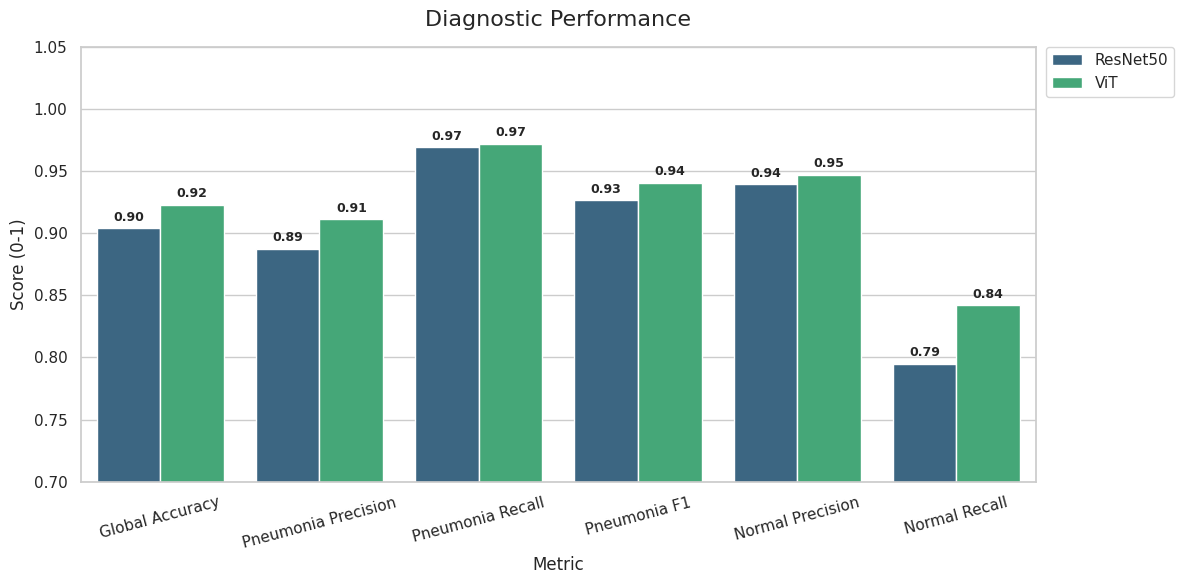

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def parse_report(report, model_name):
    return {
        'Model': model_name,
        'Global Accuracy': report['accuracy'],
        # extracting specific class metrics
        'Pneumonia Precision': report['Pneumonia']['precision'], 
        'Pneumonia Recall': report['Pneumonia']['recall'],
        'Pneumonia F1': report['Pneumonia']['f1-score'],
        'Normal Precision': report['Normal']['precision'],
        'Normal Recall': report['Normal']['recall']
    }


metrics_data = [
    parse_report(cr_cnn, 'ResNet50'),
    parse_report(cr_vit, 'ViT')
]


df = pd.DataFrame(metrics_data)
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette="viridis")


plt.title('Diagnostic Performance', fontsize=16, pad=15)
plt.ylabel('Score (0-1)')
plt.ylim(0.7, 1.05) 
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=15)


for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 8), textcoords='offset points',
                    fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()